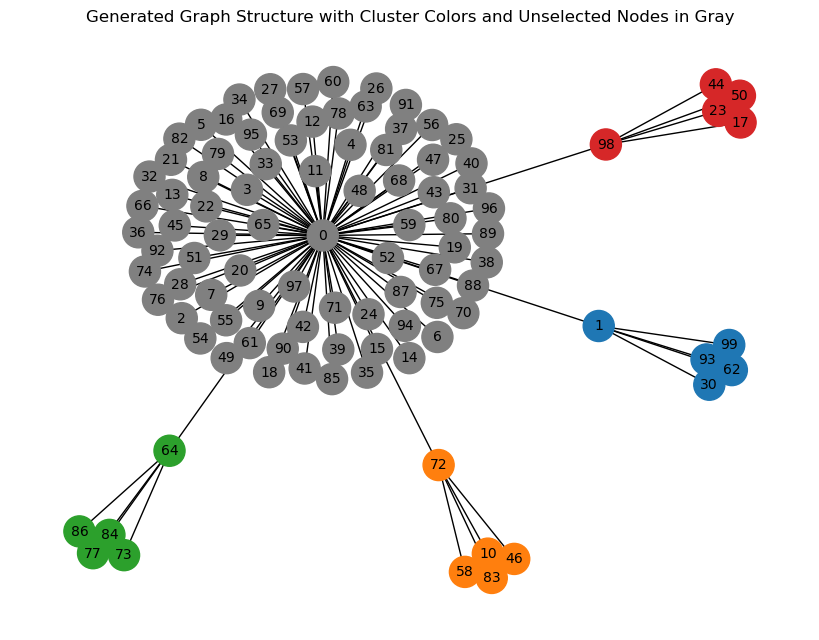

Clusters: [array([30, 93, 62, 99,  1]), array([46, 58, 10, 72, 83]), array([86, 77, 64, 73, 84]), array([17, 98, 23, 44, 50])]
Selected Features: [30 93 62 99  1 46 58 10 72 83 86 77 64 73 84 17 98 23 44 50]


In [1]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define colors for each cluster, and use gray for unselected nodes
def visualize_graph(G, clusters, selected_features):
    # Get distinct colors for clusters using matplotlib's Tableau colors
    unique_colors = list(mcolors.TABLEAU_COLORS.values())
    colors = unique_colors[:len(clusters)]  # Select enough colors for each cluster
    unselected_color = "gray"  # Color for nodes not in any cluster

    # Create a color mapping for each node
    node_colors = []
    for node in range(G.number_of_nodes()):
        if node in selected_features:
            # Find which cluster the node belongs to
            for i, cluster in enumerate(clusters):
                if node in cluster:
                    node_colors.append(colors[i % len(colors)])
                    break
        else:
            # If the node is not selected, color it gray
            node_colors.append(unselected_color)

    # Draw the graph with cluster-based colors and gray for unselected nodes
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistent visualization
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10)
    plt.title("Generated Graph Structure with Cluster Colors and Unselected Nodes in Gray")
    plt.show()


def generate_synthetic_data_with_graph(n, d, k, h, theta, gamma, visualize=False):
    # Step 1: Generate the design matrix X with i.i.d. N(0, 1) entries
    X = np.random.normal(0, 1, (n, d))
    
    # Step 2: Randomly select k features as non-zero/contributing features
    selected_features = np.random.choice(d, k, replace=False)
    
    # Step 3: Divide the selected features into h clusters
    cluster_size = k // h  # Assume k is divisible by h for simplicity TODO: imbalanced clusters
    clusters = [selected_features[i * cluster_size : (i + 1) * cluster_size] for i in range(h)]
    
    # Step 4: Construct the regression weight vector w
    w = np.zeros(d)
    for cluster in clusters:
        sign = np.random.choice([-1, 1])  # Assign same sign to all features in the cluster
        for feature in cluster:
            w[feature] = sign * (1 / np.sqrt(k))
    
    # Step 5: Create a sparse adjacency matrix for the graph
    adj_matrix = sp.lil_matrix((d, d))  # Start with a sparse matrix in List of Lists format
    
    for i in range(d):
        for j in range(i + 1, d):
            # Check if i and j are in the same cluster
            same_cluster = any(i in cluster and j in cluster for cluster in clusters)
            prob = theta if same_cluster else (1 - theta)
            
            if np.random.rand() < prob:
                adj_matrix[i, j] = 1
                adj_matrix[j, i] = 1  # Ensure symmetry
    
    # Ensure the graph is connected
    G = nx.from_scipy_sparse_array(adj_matrix)  
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        for i in range(1, len(components)):
            # Connect an isolated component to the main component
            G.add_edge(next(iter(components[i])), next(iter(components[0])))
    
    # Update the adjacency matrix after connecting components
    adj_matrix = nx.to_scipy_sparse_array(G, format="csr")
    
    # Step 6: Compute the Laplacian matrix as a sparse matrix
    degree_matrix = sp.diags(np.ravel(adj_matrix.sum(axis=1)))
    laplacian_matrix = degree_matrix - adj_matrix
    
    # Step 7: Generate the response vector y = Xw + epsilon
    epsilon = np.random.normal(0, gamma, n)
    y = X @ w + epsilon

    # Optional: Visualize the graph with cluster-based colors
    if visualize:
        visualize_graph(G, clusters, selected_features=selected_features)
    
    # # Optional: Visualize the graph
    # plt.figure(figsize=(8, 6))
    # nx.draw(G, with_labels=True, node_color="skyblue", node_size=500, font_size=10)
    # plt.title("Generated Graph Structure")
    # plt.show()
    
    return X, w, y, adj_matrix, laplacian_matrix, clusters, selected_features

# Parameters
n = 100  # Number of samples
d = 100   # Number of features
k = 20   # Number of non-zero features
h = 4    # Number of clusters
theta = 1  # Probability of connection within clusters
gamma = 0.1  # Noise standard deviation

# Generate synthetic data
X, w, y, adj_matrix, laplacian_matrix, clusters, selected_features = generate_synthetic_data_with_graph(n, d, k, h, theta, gamma, visualize=True)

# Print outputs for inspection
# print("Design Matrix X:", X)
# print("Weight Vector w:", w)
# print("Response Vector y:", y)
# print("Adjacency Matrix (Sparse):\n", adj_matrix.toarray())
# print("Laplacian Matrix (Sparse):\n", laplacian_matrix.toarray())
print("Clusters:", clusters)
print("Selected Features:", selected_features)


In [2]:
from gurobipy import Model, GRB, QuadExpr
def ProjOperator_Gurobi(m, k, d, h):
    """
    This function we return a projection operator that projects the input vector m onto the simplex
    Parameters:
    - m: input vector (maybe in it matrix form -- no)
    - k: sparsity level
    - d: number of features
    - h: number of pre-defined clusters, which can be read from the input vector m (omit for now, since we pass the vector form, so we cannot know d and h directly)
    """

    # Create constraint matrix A for the sparsity level
    A = np.ones((1, d*h))
    b = np.array([k])

    # Create constraint matrix B for each feature belongs to at most one cluster
    # Initialize B as an empty matrix with shape (0, d*h)
    B = np.empty((0, d*h))

    # Initialize c as an empty array
    c = np.empty((0, 1))

    for i in range(d):
        # Create a new row of zeros with shape (1, d*h)
        B_row = np.zeros(d*h)
        # Set a specific element in the row to 1
        B_row[i*h: (i+1)*h] = 1

        # Stack the new row onto B
        B = np.vstack([B, B_row]) 

        # Append 1 to vector c
        c = np.vstack([c, [[1]]])

    # Concatenate A and B to create the constraint matrix
    C = np.vstack([A, B])
    Cb = np.vstack([b, c])

    # Create a Gurobi model
    model = Model()

    # Add variables
    x = model.addMVar(d*h, lb=0.0, ub=1.0)

    # Set objective function
    Q = np.eye(d*h)
    f = -2*m.flatten()
    x = model.addMVar(d*h, ub=1.0, lb=0.0)
    model.setObjective(x@Q@x + x@f)
    model.addConstr(C @ x <= Cb)

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    # Optimize model
    model.optimize()

    # Get the results
    x = x.x

    return x[:, np.newaxis]


In [ ]:
# Parameters
n = 100  # Number of samples
d = 100   # Number of features
k = 20   # Number of non-zero features
h = 4    # Number of clusters
theta = 1  # Probability of connection within clusters
gamma = 0.1  # Noise standard deviation

# Generate synthetic data
X, w, y, adj_matrix, laplacian_matrix = generate_synthetic_data_with_graph(n, d, k, h, theta, gamma)


In [3]:
import os

# Get the current working directory
cwd = os.getcwd()

# Print it
print("Current Working Directory:", cwd)


Current Working Directory: /Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl


In [7]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time

from L0Obj import L0Obj
from ProjCSimplex import ProjCSimplex
from minConf.minConf_PQN import minConF_PQN
import random


tStart = time.process_time()
# Generate synthetic data
# Parameters
n = 100  # Number of samples
d = 100   # Number of features
k = 20   # Number of non-zero features
h = 4    # Number of clusters
nVars = d*h # Number of Boolean variables in m
theta = 1  # Probability of connection within clusters
gamma = 0.1  # Noise standard deviation
pho = 0.2
mu = 0.2
SNR = 1

# Generate synthetic data
X, w_true, y, adj_matrix, L, clusters, selected_features = generate_synthetic_data_with_graph(n, d, k, h, theta, gamma)

# we need to modify the matrix X to define the objective function
X_hat = np.repeat(X, h, axis=1)


print("Check!!!")
tEnd = time.process_time() - tStart
print("Execution time (generating the data):", tEnd)

# Initial guess of parameters
m_initial = np.ones((nVars, 1)) * (1 / nVars)


# Set up Objective Function L0Obj(X, m, y, pho, mu):
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h)

# Set up Simplex Projection Function
funProj = lambda m: ProjOperator_Gurobi(m, k, d, h)

tEnd = time.process_time() - tStart
print("Execution time(Before):", tEnd)
print("start!!!")
# Solve with PQN
options = {'maxIter': 50}
tStart = time.process_time()
uout, obj, _ = minConF_PQN(funObj, m_initial, funProj, options)
print(f"uout: {uout}")
tEnd = time.process_time() - tStart

B = np.sort(-uout.flatten())
Ranktmp = np.argsort(-uout.flatten())
Rank = np.sort(Ranktmp[:k])
# uout[Ranktmp[:k[0][0]]]

Indtrue = np.where(utrue)
# print(Rank)
# print("IndTrue", Indtrue)
# print(f"Indtrue: {Indtrue}, Rank: {Rank}")
C = np.intersect1d(Rank, Indtrue)
# Convert numpy arrays to tuples, if necessary
# Rank_tuple = [tuple(r) for r in Rank]
# Indtrue_tuple = [tuple(i) for i in Indtrue]

# Find the intersection
AccPQN = len(C) / k

print("Execution time:", tEnd)
print("Accuracy PQN:", AccPQN)


Check!!!
Execution time (generating the data): 0.0587219999999995
Execution time(Before): 0.06173899999999932
start!!!
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond


ValueError: operands could not be broadcast together with shapes (400,) (100,4) 

In [26]:
import numpy as np

# Example matrix X
X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# Number of repetitions per column
h = 2

# Repeat each column h times
X_repeated = np.repeat(X, h, axis=1)

print("Original Matrix X:")
print(X)

print("\nNew Matrix with Columns Repeated:")
print(X_repeated)


Original Matrix X:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

New Matrix with Columns Repeated:
[[1 1 2 2 3 3]
 [4 4 5 5 6 6]
 [7 7 8 8 9 9]]


In [11]:
import numpy as np
# read the data
data = np.load('synthetic_data.npz', allow_pickle=True)
print(data)

NpzFile 'synthetic_data.npz' with keys: X, w, y, adj_matrix, laplacian_matrix...


In [13]:
print(data['adj_matrix'])

  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 20)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 25)	1.0
  (0, 26)	1.0
  :	:
  (181, 0)	1.0
  (182, 0)	1.0
  (183, 0)	1.0
  (184, 0)	1.0
  (185, 0)	1.0
  (186, 44)	1.0
  (186, 92)	1.0
  (186, 131)	1.0
  (186, 149)	1.0
  (187, 58)	1.0
  (187, 82)	1.0
  (187, 83)	1.0
  (187, 114)	1.0
  (188, 0)	1.0
  (189, 0)	1.0
  (190, 0)	1.0
  (191, 0)	1.0
  (192, 0)	1.0
  (193, 0)	1.0
  (194, 0)	1.0
  (195, 0)	1.0
  (196, 0)	1.0
  (197, 0)	1.0
  (198, 0)	1.0
  (199, 0)	1.0


In [14]:
dense_array = adj_matrix.toarray()  # Converts sparse matrix to dense

print(dense_array)

[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [15]:
# i want to check if the graph represented by the adjacency matrix is connected
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(dense_array)

# Check if the graph is connected
is_connected = nx.is_connected(G)
print("Is the graph connected?", is_connected)

Is the graph connected? True


In [2]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time

from L0Obj import L0Obj
from data_generator import generate_synthetic_data_with_graph, read_synthetic_data_from_file, save_synthetic_data_to_file
from ProjectOperator import ProjOperator_Gurobi
from minConf.minConf_PQN import minConF_PQN
import random


tStart = time.process_time()
# Generate synthetic data
# Parametersx
n = 500  # Number of samples
d = 300   # Number of features
k = 10   # Number of non-zero features
h = 2    # Number of clusters
nVars = d*h # Number of Boolean variables in m
theta = 1  # Probability of connection within clusters
gamma = 1.5  # Noise standard deviation
pho = np.sqrt(n)
mu = np.sqrt(n/2)
SNR = 1

fixed_seed = 1
# read a fixed synthetic data from a file if fixed_seed is True because we want to compare the results with the original results
if fixed_seed:
    file_path = "synthetic_data.npz"
    X, w_true, y, adj_matrix, L, clusters_true, selected_features_true = read_synthetic_data_from_file(file_path)
else:
    # Generate synthetic data
    X, w_true, y, adj_matrix, L, clusters_true, selected_features_true = generate_synthetic_data_with_graph(n, d, k, h, theta, gamma, visualize=True)
    # Save the synthetic data to a file
    file_path = "synthetic_data.npz"
    save_synthetic_data_to_file(file_path, X, w_true, y, adj_matrix, L, clusters_true, selected_features_true)

print("selected_features_true", selected_features_true)
print("clusters_true", clusters_true)

# we need to modify the matrix X to define the objective function
X_hat = np.repeat(X, h, axis=1)
# print("w_true:", w_true) 

print("Check!!!")
tEnd = time.process_time() - tStart
print("Execution time (generating the data):", tEnd)

# Initial guess of parameters
m_initial = np.ones((nVars, 1)) * (1 / nVars)


# Set up Objective Function L0Obj(X, m, y, L, pho, mu, d, h)::
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h)

# Set up Simplex Projection Function ProjOperator_Gurobi(m, k, d, h):
funProj = lambda m: ProjOperator_Gurobi(m, k, d, h)

reading the synthetic data from the file synthetic_data.npz
(1000, 300) (300,) (1000,) (300, 300) (300, 300) (5, 4) (20,)
selected_features_true [ 27  35 182 204   7  29  72  96 233 212 142 203 150 297  76 137  70 114
 174 268]
clusters_true [[ 27  35 182 204]
 [  7  29  72  96]
 [233 212 142 203]
 [150 297  76 137]
 [ 70 114 174 268]]
Check!!!
Execution time (generating the data): 0.003198999999999952


In [3]:
import scipy.sparse as sp
def read_synthetic_data_from_file(file_path):
    print("reading the synthetic data from the file", file_path)
    with np.load(file_path, allow_pickle=True) as data:
        X = data["X"]
        w = data["w"]
        y = data["y"]
        clusters = data["clusters"]
        selected_features = data["selected_features"]
    adj_matrix = sp.load_npz(file_path.replace(".npz", "_adj_matrix.npz"))
    laplacian_matrix = sp.load_npz(file_path.replace(".npz", "_laplacian_matrix.npz"))
    print(X.shape, w.shape, y.shape, adj_matrix.shape, laplacian_matrix.shape, clusters.shape, selected_features.shape)
    return X, w, y, adj_matrix, laplacian_matrix, clusters, selected_features

data = read_synthetic_data_from_file("synthetic_data.npz")

print(data[1])

reading the synthetic data from the file synthetic_data.npz
(1000, 300) (300,) (1000,) (300, 300) (300, 300) (5, 4) (20,)
[ 0.          0.          0.          0.          0.          0.
  0.         -0.77841166  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -1.54262619  0.         -0.77841166
  0.          0.          0.          0.          0.         -1.54262619
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.27552618  0.
 -0.77841166  0.          0.          0.         -0.7201089   0.
  0.          0. 

In [4]:
# read from the .mat file
mout = sio.loadmat('mout.mat')['mout']
print("clusters_true", clusters_true)  
print("selected_features_true", selected_features_true)
# round the result randomly according to its value for a few times and select the best one in terms of the objective function
def test(T):
    min_obj = np.inf
    min_round = np.zeros((nVars, ))  # initialize the best result
    m_grouped = mout.reshape(d, h)
    """
    here we propose a different way to round this result. note that we have introduce h times more variables than the original problem. so the number are diluted, it is hard to get more than a lot of ones in the result if we round it according to its probability. because even the selected one are very small.

    so we need to, first, treat variables associated with the same feature as a whole, take the sum, and then round it according to the probability to determine whether this feature is selected or not. Then, for the selected features, we need to determine which cluster it belongs to according to the probability.
    """
    for _ in range(T):
        one_realization = np.zeros((d, h))
        feature_round = (np.random.rand(d)<np.sum(m_grouped, axis=1)).astype(int)

        for i in range(d):
            if feature_round[i] == 1:
                cluster = np.random.choice(h, p=m_grouped[i]/np.sum(m_grouped[i])) # TODO: another choice is to introduce a temperature parameter to control the randomness or an extra "discard" choice with the 1- sum(m_grouped[i]) probability
                one_realization[i, cluster] = 1

        m_round = one_realization.flatten()
        obj = funObj(m_round)[0]
        if obj < min_obj:
            min_obj = obj
            min_round = m_round

    tEnd = time.process_time() - tStart

    # print("min_obj", min_obj)
    # print("min_round", min_round)

    selected_features_predict = []
    clusters_predict = {}
    # parse the result m_round to the selected features and clusters
    m = min_round.reshape(d, h)
    for i in range(d):
        if np.sum(m[i]) > 0:
            selected_features_predict.append(i)
            cluster = np.where(m[i] > 0)[0][0]
            if cluster in clusters_predict:
                clusters_predict[cluster].append(i)
            else:
                clusters_predict[cluster] = [i]

    # find the intersection of the selected features and clusters
    C = np.intersect1d(selected_features_true, selected_features_predict)

    # Find the intersection
    AccPQN = len(C) / k

    print("Accuracy PQN:", AccPQN)
    print("clusters_predict", clusters_predict)

    print("selected_features_predict", selected_features_predict)
    return AccPQN


clusters_true [[ 27  35 182 204]
 [  7  29  72  96]
 [233 212 142 203]
 [150 297  76 137]
 [ 70 114 174 268]]
selected_features_true [ 27  35 182 204   7  29  72  96 233 212 142 203 150 297  76 137  70 114
 174 268]


In [5]:
T = [1, 10, 100, 500, 1000]
res = []
for t in T:
    acc = test(t)
    res.append(acc)


Accuracy PQN: 0.1
clusters_predict {1: [112]}
selected_features_predict [112]
Accuracy PQN: 0.1
clusters_predict {0: [266], 1: [270]}
selected_features_predict [266, 270]
Accuracy PQN: 0.2
clusters_predict {1: [77, 266], 0: [294]}
selected_features_predict [77, 266, 294]
Accuracy PQN: 0.3
clusters_predict {1: [77, 90, 210]}
selected_features_predict [77, 90, 210]
Accuracy PQN: 0.3
clusters_predict {1: [29, 90, 210, 270], 0: [281]}
selected_features_predict [29, 90, 210, 270, 281]


In [6]:
T = [5000 , 6000, 10000]
res = []
for t in T:
    acc = test(t)
    res.append(acc)


Accuracy PQN: 0.5
clusters_predict {0: [77, 90, 210], 1: [112, 270]}
selected_features_predict [77, 90, 112, 210, 270]
Accuracy PQN: 0.3
clusters_predict {1: [77, 90, 210]}
selected_features_predict [77, 90, 210]
Accuracy PQN: 0.3
clusters_predict {0: [77, 90, 210]}
selected_features_predict [77, 90, 210]


In [18]:
# we use rank instead of random rounding
mout = sio.loadmat('mout.mat')['mout']
m_grouped = mout.reshape(300, 5)

feature_prob = np.sum(m_grouped, axis=1)
feature_rank = np.argsort(np.abs(feature_prob))[::-1]

print("feature_rank", feature_rank[:25])

feature_rank [251 207 137 105 180 155 234 272 119  21 125  41 206  84 209 100  34 182
 253 177  95 256 143 133 186]


In [38]:
selected_features_true = [268, 25, 223, 86, 78, 210, 232, 205, 266, 264, 279, 73, 204, 194, 293, 176, 55, 297, 15, 140]
intersect = np.intersect1d(selected_features_true, feature_rank[:20])
print("intersect", len(intersect)/20)
print("wrong", [x for x in feature_rank[:20] if x not in selected_features_true])
print("missed", [x for x in selected_features_true if x not in feature_rank[:20]])

intersect 0.95
wrong [111]
missed [293]


In [26]:
print(mout)

[[1.05436526e-12 1.05436526e-12 1.05436526e-12 ... 1.06180790e-12 1.06180790e-12 1.06180790e-12]]


In [28]:
# Save the matrix to a text file
np.savetxt("matrix_output.txt", mout)  # Adjust '%.2f' as needed for precision

In [29]:
mout.reshape(300, 5)

array([[1.05436526e-12, 1.05436526e-12, 1.05436526e-12, 1.05436526e-12, 1.05436526e-12],
       [1.06372642e-12, 1.06372642e-12, 1.06372642e-12, 1.06372642e-12, 1.06372642e-12],
       [1.13941691e-12, 1.13941691e-12, 1.13941691e-12, 1.13941691e-12, 1.13941691e-12],
       ...,
       [1.31416776e-02, 1.31416776e-02, 1.31416776e-02, 1.31416776e-02, 1.31416776e-02],
       [1.05373087e-12, 1.05373087e-12, 1.05373087e-12, 1.05373087e-12, 1.05373087e-12],
       [1.06180790e-12, 1.06180790e-12, 1.06180790e-12, 1.06180790e-12, 1.06180790e-12]])

In [40]:
m_grouped = mout.reshape(300, 5)
feature_prob = np.sum(m_grouped, axis=1)
feature_rank = np.argsort(np.abs(feature_prob))[::-1]
selected_features_predict = feature_rank[:20]
clusters_predict = {}
for i in selected_features_predict:
    cluster = np.argmax(m_grouped[i])
    print("the feature", m_grouped[i])
    print("the maximum probability", m_grouped[i][cluster])
    print("the sum of the probability", np.sum(m_grouped[i]))
    print("cluster", cluster)
    if cluster in clusters_predict:
        clusters_predict[cluster].append(i)
    else:
        clusters_predict[cluster] = [i]

the feature [0.015631 0.015631 0.015631 0.015631 0.015631]
the maximum probability 0.015631002748355164
the sum of the probability 0.07815501374177582
cluster 0
the feature [0.01549332 0.01549332 0.01549332 0.01549332 0.01549332]
the maximum probability 0.015493315928677706
the sum of the probability 0.07746657964338853
cluster 0
the feature [0.01494724 0.01494724 0.01494724 0.01494724 0.01494724]
the maximum probability 0.014947238456430105
the sum of the probability 0.07473619228215053
cluster 0
the feature [0.01484699 0.01484699 0.01484699 0.01484699 0.01484699]
the maximum probability 0.014846993507582685
the sum of the probability 0.07423496753791342
cluster 0
the feature [0.01154592 0.01154592 0.01154592 0.01154592 0.01154592]
the maximum probability 0.011545919979338234
the sum of the probability 0.05772959989669117
cluster 0
the feature [0.01142099 0.01142099 0.01142099 0.01142099 0.01142099]
the maximum probability 0.011420993435985126
the sum of the probability 0.057104967179

In [35]:
data[1]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  1.59165491,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.85980853,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  1.59165491,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        , -1.16305432,  0.        ,  0.        ,  0.  

In [41]:
data[2]

array([ 5.99532627e+00,  8.37979212e+00, -6.19597740e+00,  2.70735328e+00, -4.08454966e+00, -3.47580513e+00,  2.40030913e+00,  4.76595919e+00,  4.59633319e+00,  2.58532325e+00,  4.02812738e+00, -2.76050712e+00,  4.43518024e+00, -5.79315301e+00,  1.01747735e+01, -1.65999940e+00,  5.92127111e+00, -4.73766378e+00, -1.92917257e+00, -1.80120581e+00, -1.15454573e+01,  2.37346114e+00,  6.05224950e+00,  6.39547188e+00, -4.15951145e+00,  1.18680894e+00,  4.92147732e+00, -6.12914750e+00,  1.26458602e+01, -7.15899158e+00,  9.36676385e+00, -2.94141013e-01,  6.35088414e+00,  1.08514261e+00,  2.69839312e+00, -8.65499659e+00,  1.42324640e+00, -8.38570471e+00, -3.62910990e+00, -6.06965458e+00, -3.87384233e+00, -1.03992245e+01,  1.79438516e+00,  6.87737282e+00,  2.64678515e+00, -6.75903742e+00,  1.41766694e+00, -1.96940252e+00,  3.68735388e-01, -1.27928885e+01, -4.55011771e-01,  4.10821528e+00,  4.26273691e+00,  1.41652990e+00,  3.22561925e+00,  3.70616934e-01, -5.32387697e+00, -5.05169368e+00, -5.2689

In [15]:
import numpy as np
from scipy.sparse import spdiags
from scipy.linalg import inv

def L0Obj_separate(X, m, y, L, pho, mu, d, h):
    """
    Compute the objective function value and gradient for the L0 regularized least squares problem.
    Parameters:
    - X: n x d matrix of features
    - y: n x 1 vector of labels
    - pho: regularization parameter for L2 penalty
    - mu: regularization parameter for L0-graph penalty
    - u: d x 1 vector of weights
    Returns:
    - f: objective function value
    - g: gradient
    """
    n, dh = X.shape
    if d*h != dh:
        raise ValueError("The dimensions of X and d*h do not match.")
    
    SpDiag = spdiags(m.flatten(), 0, dh, dh)
    # print(SpDiag)
    # print(f"SpDiag: {SpDiag.toarray()[-1][-1]}")
    M = inv((1/pho) * X @ SpDiag @ X.T + np.eye(n))
    # generate the correspodning assignment matrix
    assignemen_matrix = m.reshape(d,h)
    # print(f"assignemen_matrix: {assignemen_matrix}")
    # print(f"m: {m}")
    # generate the graph penalty term
    graph_penalty = mu * np.trace(assignemen_matrix.T @ L @ assignemen_matrix)
    precision_penalty = y.T @ M @ y
    f = precision_penalty + graph_penalty # AL: why conjuate transpose? i remove the .conj()

    A_grad = -(1/pho) * ((X.conj().T @ M @ y)**2) # the gradient of the first term
    B_grad = 2 * mu * L @ assignemen_matrix # the gradient of the second term

    g = A_grad + B_grad.flatten()

    return f, g, graph_penalty, precision_penalty


X_hat = np.repeat(X, h, axis=1)
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h)

pho = 1
mu = 5000
funObj_separate = lambda m: L0Obj_separate(X_hat, m, y, L, pho, mu, d, h)


In [10]:
n = 1000  # Number of samples
d = 300   # Number of features
k = 20   # Number of non-zero features
h = 5    # Number of clusters
nVars = d*h # Number of Boolean variables in m
theta = 1  # Probability of connection within clusters
res = funObj(mout)

In [20]:
res = funObj_separate(mout)
print("f:", res[0])
print("g:", res[1])
print("graph_penalty:", res[2])
print("precision_penalty:", res[3])

f: 9638.273464729476
g: [-318.24351693 -318.24351693 -318.24351693 ...  -87.70187323  -87.70187324
  -87.70187324]
graph_penalty: 579.5244537873015
precision_penalty: 9058.749010942174


In [53]:
m_initial = np.random.normal(0, 1, (nVars, 1))
# can we choose a better initial value? with a lot of 
res_initial = funObj_separate(m_initial)
print("f_initial:", res_initial[0])
print("g_initial:", res_initial[1])
print("graph_penalty_initial:", res_initial[2])
print("precision_penalty_initial:", res_initial[3])


f_initial: 57689.06201212855
g_initial: [-19811.58477181   2271.89635882  13173.93150244 ...   -100.09607429     63.83732133     23.56499984]
graph_penalty_initial: 57294.7446159413
precision_penalty_initial: 394.3173961872461


In [52]:
m_initial

array([[0.00066667],
       [0.00066667],
       [0.00066667],
       ...,
       [0.00066667],
       [0.00066667],
       [0.00066667]])

In [17]:
def add_noise_to_signal(signal, desired_snr_db):
    # Convert signal to numpy array
    signal = np.asarray(signal)
    # Calculate signal power
    signal_power = np.mean(signal ** 2)
    # Calculate the desired noise power based on the desired SNR (in dB)
    desired_snr_linear = 10 ** (desired_snr_db / 10)
    noise_power = signal_power / desired_snr_linear
    # Generate noise with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    # Add noise to the original signal
    noisy_signal = signal + noise
    return noisy_signal, noise
 
 
def compute_snr(signal, noise):
    # Convert signal and noise to numpy arrays for calculations
    signal = np.asarray(signal)
    noise = np.asarray(noise)
 
    # Calculate the power of the signal and the noise
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    # Calculate the SNR
    snr = signal_power / noise_power
    # Convert SNR to decibels (dB)
    snr_db = 10 * np.log10(snr)
    return snr_db



 
 
def SynData_iid_L0Sparse(n, p, t, snr):
    #n: the number of samples
    #p: the number of features
    #t: the number of ture features
    #snr: signal-noise-ratio snr = 10*log_10 E[S^2]/E[N^2] 
    # hard coding sparsity setting
    #Sparse = [10,10,10,10,10]#[8, 6, 4, 2, 1]
    #Group = {}
    #for i in range(len(Sparse)):
    #    Group[i] = 100*i + np.random.permutation(int(p/b))[0:Sparse[i]]
    # print(Group)
 
    Mean = np.zeros(p)
    Cov = np.eye(p)
    X = np.random.multivariate_normal(Mean, Cov, n)
    print(X.shape)
    w = np.zeros(p)
    Ind = np.random.permutation(p)[0:t]
    w[Ind] = 2*np.random.randint(0, 2, size=t) -1
    w = w[:,np.newaxis]
    Signal = X.dot(w)
 
    Noisy_Signal, Noise = add_noise_to_signal(Signal, snr)
 
    SNR_Cmp = compute_snr(Signal, Noise)
    print("Computed SNR:", SNR_Cmp)
 
    y = Noisy_Signal

 
    return y, X, w